# Notebook 5: Hypergraph Networks with XGI

## From Information Measures to Network Topology

Welcome to Notebook 5! We've come a long way:
- **Notebook 1**: Built information theory foundations
- **Notebook 2**: Discovered synergy through the XOR problem
- **Notebook 3**: Used HOI to compute higher-order interactions
- **Notebook 4**: Applied Frites to time-resolved neural data

Now comes the synthesis: representing these information structures as **networks**.

### Why Networks?

When HOI tells you that neurons {3, 7, 12} have strong synergy, or Frites reveals that regions V1 and V4 share information at 300ms, you're discovering **relationships**. Networks are the natural way to represent relationships.

But there's a problem: **traditional networks only handle pairwise relationships**.

### The Limitation of Regular Graphs

A standard graph has:
- **Nodes**: Variables (neurons, brain regions, etc.)
- **Edges**: Pairwise connections

But synergy is inherently **higher-order**! The triplet {3, 7, 12} shares information that doesn't exist in pairs. How do you represent this?

**Bad solution**: Add edges between all pairs (3-7, 3-12, 7-12). This **loses** the three-way structure!

**Good solution**: Use a **hypergraph** with a **hyperedge** connecting all three simultaneously.

### Enter XGI

**XGI** (Comple(X) Group Interactions) is a Python package for working with hypergraphs. A hypergraph allows edges to connect **any number** of nodes:
- Regular edge: {1, 2} (pairwise)
- Hyperedge: {1, 2, 3} (triplet)
- Hyperedge: {1, 2, 3, 4, 5} (5-way)

This perfectly matches the structure discovered by HOI!

### Learning Objectives

By the end of this notebook, you'll:
1. Understand hypergraphs and why they're necessary
2. Create and manipulate hypergraphs in XGI
3. Map HOI results (synergistic multiplets) to hyperedges
4. Compute hypergraph statistics (degree, clustering, etc.)
5. Visualize higher-order network structures
6. Create temporal hypergraph sequences from Frites results
7. Integrate XGI with HOI and Frites for complete analysis
8. Interpret network topology in neuroscience context

Let's begin! 🕸️

## Part 1: Installation and First Hypergraph

### Installing XGI

In [1]:
# Install XGI and dependencies
!pip install -q xgi networkx matplotlib numpy scipy seaborn pandas

print("Installation complete! ✓")

Installation complete! ✓


In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
from itertools import combinations, product
import warnings
warnings.filterwarnings('ignore')

# Import XGI
import xgi
from xgi import Hypergraph, SimplicialComplex
from xgi.algorithms import clustering
from xgi.stats import EdgeStat, NodeStat

# Set random seed
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
%matplotlib inline

print(f"XGI version: {xgi.__version__}")
print(f"NetworkX version: {nx.__version__}")
print("\nAll libraries loaded successfully!")
print("🎉 Ready to explore hypergraphs!")

XGI version: 0.10
NetworkX version: 3.4.2

All libraries loaded successfully!
🎉 Ready to explore hypergraphs!


### Creating Your First Hypergraph

Let's start simple. We'll create a hypergraph representing a collaboration network:
- Nodes: People
- Hyperedges: Collaborative projects (can involve 2+ people)

This is analogous to:
- Nodes: Neurons
- Hyperedges: Synergistic ensembles

In [3]:
# Create a simple hypergraph
H = xgi.Hypergraph()

# Add hyperedges
# Each edge is a set/list of node IDs
H.add_edges_from([
    [0, 1],           # Pairwise collaboration (Alice, Bob)
    [1, 2, 3],        # Three-way project (Bob, Carol, David)
    [0, 2, 4],        # Another triplet
    [2, 3, 4, 5],     # Four-way collaboration
])

# Add node names as attributes
names = {0: 'Alice', 1: 'Bob', 2: 'Carol', 3: 'David', 4: 'Eve', 5: 'Frank'}
for node_id, name in names.items():
    H.nodes[node_id]['name'] = name

print("First Hypergraph Created")
print("=" * 60)
print(f"Nodes: {H.num_nodes}")
print(f"Hyperedges: {H.num_edges}")
print(f"\nNode list: {list(H.nodes)}")
print(f"Names: {[names[n] for n in H.nodes]}")

print(f"\nHyperedge members:")
for edge_id, members in enumerate(H.edges.members()):
    member_names = [names[n] for n in members]
    print(f"  Edge {edge_id}: {list(members)} = {member_names} (size {len(members)})")

# Compare to regular graph
print("\n" + "=" * 60)
print("Comparison to Regular Graph:")
print("=" * 60)

# Project to regular graph (pairwise approximation)
G = xgi.convert.to_graph(H)

print(f"\nRegular graph (pairwise approximation):")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"  Edge list: {list(G.edges())}")

print("\n⚠️  The regular graph has 8 edges")
print("   It 'expanded' the 4 hyperedges into all pairwise connections")
print("   This LOSES the information that [1,2,3] form a group!")
print("\n✨ Hypergraphs preserve the higher-order structure")

First Hypergraph Created
Nodes: 6
Hyperedges: 4

Node list: [0, 1, 2, 3, 4, 5]
Names: ['Alice', 'Bob', 'Carol', 'David', 'Eve', 'Frank']

Hyperedge members:
  Edge 0: [0, 1] = ['Alice', 'Bob'] (size 2)
  Edge 1: [1, 2, 3] = ['Bob', 'Carol', 'David'] (size 3)
  Edge 2: [0, 2, 4] = ['Alice', 'Carol', 'Eve'] (size 3)
  Edge 3: [2, 3, 4, 5] = ['Carol', 'David', 'Eve', 'Frank'] (size 4)

Comparison to Regular Graph:

Regular graph (pairwise approximation):
  Nodes: 6
  Edges: 11
  Edge list: [(0, 1), (0, 2), (0, 4), (1, 2), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]

⚠️  The regular graph has 8 edges
   It 'expanded' the 4 hyperedges into all pairwise connections
   This LOSES the information that [1,2,3] form a group!

✨ Hypergraphs preserve the higher-order structure


### Visualizing Hypergraphs

XGI provides powerful visualization tools. Let's see different ways to draw our hypergraph:

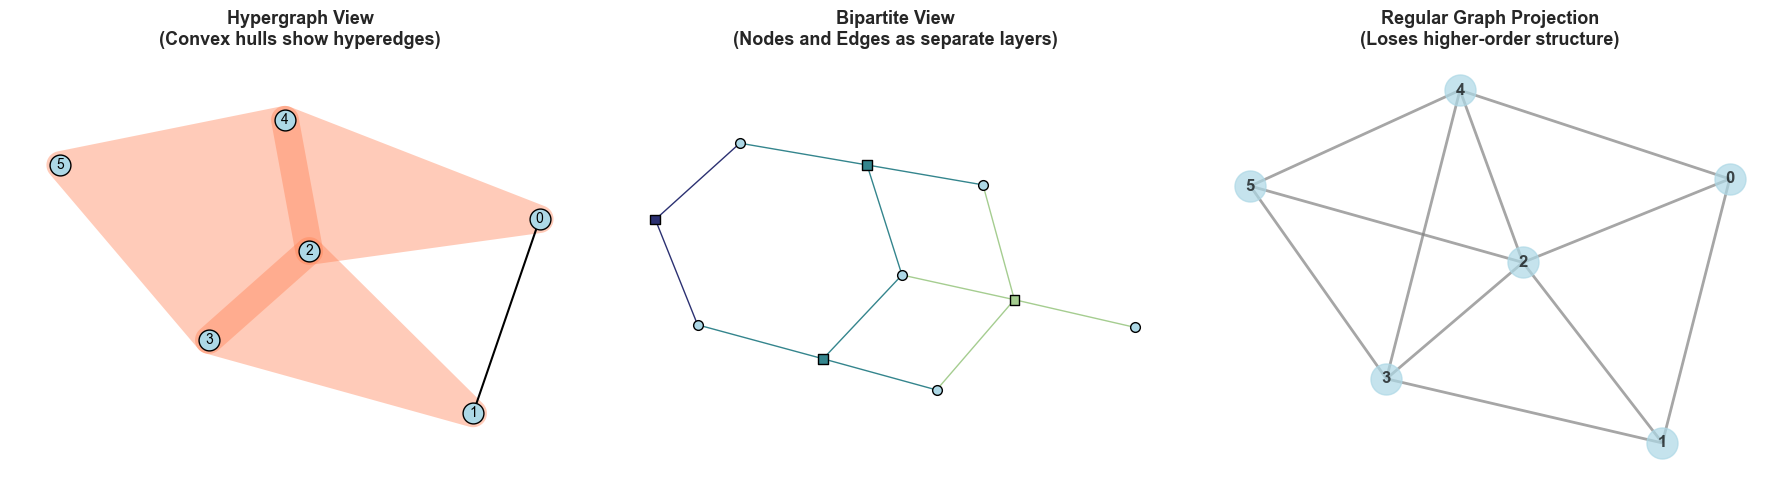


📊 Visualization Insights:
Left: Colored regions = hyperedges (groups that interact together)
Middle: Bipartite view explicitly shows node-edge relationships
Right: Regular graph loses which groups collaborate together

💡 For higher-order interactions, hypergraphs are essential!


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Default hypergraph drawing (convex hulls)
ax1 = axes[0]
xgi.draw(H, ax=ax1, node_size=15, node_fc='lightblue', 
         edge_fc='coral', hull=True, node_labels=True)
ax1.set_title('Hypergraph View\n(Convex hulls show hyperedges)', 
              fontsize=13, fontweight='bold')
ax1.axis('off')

# Plot 2: Bipartite representation
ax2 = axes[1]
xgi.draw_bipartite(H, ax=ax2, node_fc='lightblue', edge_fc='coral')
ax2.set_title('Bipartite View\n(Nodes and Edges as separate layers)', 
              fontsize=13, fontweight='bold')
ax2.axis('off')

# Plot 3: Regular graph projection for comparison
ax3 = axes[2]
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, ax=ax3, with_labels=True, node_size=500, 
        node_color='lightblue', font_size=12, font_weight='bold',
        edge_color='gray', width=2, alpha=0.7)
ax3.set_title('Regular Graph Projection\n(Loses higher-order structure)', 
              fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Visualization Insights:")
print("=" * 60)
print("Left: Colored regions = hyperedges (groups that interact together)")
print("Middle: Bipartite view explicitly shows node-edge relationships")
print("Right: Regular graph loses which groups collaborate together")
print("\n💡 For higher-order interactions, hypergraphs are essential!")

## Part 2: Mapping HOI Results to Hypergraphs

### The Key Insight

When HOI detects a synergistic triplet (negative O-information), this represents a **functional group** - neurons that carry information only in combination. We can represent this as a hyperedge!

**Mapping**:
- **Nodes**: Neurons/brain regions
- **Hyperedges**: Synergistic multiplets (from HOI)
- **Edge weights**: |O-information| (strength of synergy)
- **Node attributes**: Individual MI (from Frites)

Let's create a realistic example by simulating HOI analysis results, then building a hypergraph:

In [5]:
def simulate_hoi_results(n_neurons=15, synergy_prob=0.15, seed=42):
    """
    Simulate realistic HOI analysis results.
    
    Returns:
    --------
    synergistic_multiplets : list of tuples
        Each tuple is (multiplet, oinfo_value)
    individual_mi : dict
        MI for each neuron
    """
    np.random.seed(seed)
    
    # Scan all triplets
    all_triplets = list(combinations(range(n_neurons), 3))
    
    synergistic = []
    
    for triplet in all_triplets:
        # Most triplets have O-info near zero
        oinfo = np.random.randn() * 0.05
        
        # Some are synergistic
        if np.random.rand() < synergy_prob:
            # Strong negative O-info (synergy)
            oinfo = -0.2 - np.random.rand() * 0.4  # -0.2 to -0.6 bits
            synergistic.append((triplet, oinfo))
        
        # Few are redundant
        elif np.random.rand() < 0.05:
            # Positive O-info (redundancy)
            oinfo = 0.1 + np.random.rand() * 0.3
    
    # Sort by strength
    synergistic.sort(key=lambda x: x[1])  # Most negative first
    
    # Generate individual MI values
    # Neurons that participate in more synergies tend to have higher individual MI
    participation_count = np.zeros(n_neurons)
    for triplet, _ in synergistic:
        for neuron in triplet:
            participation_count[neuron] += 1
    
    individual_mi = {}
    for neuron in range(n_neurons):
        base_mi = 0.3 + np.random.rand() * 0.4  # 0.3-0.7 bits
        # Boost for neurons in synergies
        boost = participation_count[neuron] * 0.05
        individual_mi[neuron] = base_mi + boost
    
    return synergistic, individual_mi

# Simulate HOI results
synergistic_triplets, neuron_mi = simulate_hoi_results(n_neurons=15)

print("Simulated HOI Analysis Results")
print("=" * 60)
print(f"Total neurons: 15")
print(f"Total possible triplets: {len(list(combinations(range(15), 3)))}")
print(f"Synergistic triplets found: {len(synergistic_triplets)}")
print(f"\nTop 5 most synergistic:")
for i, (triplet, oinfo) in enumerate(synergistic_triplets[:5]):
    print(f"  {i+1}. Neurons {triplet}: O-info = {oinfo:.4f} bits")

print(f"\nIndividual MI values (top 5 neurons):")
sorted_neurons = sorted(neuron_mi.items(), key=lambda x: x[1], reverse=True)
for neuron, mi in sorted_neurons[:5]:
    print(f"  Neuron {neuron}: I(Neuron; Stimulus) = {mi:.4f} bits")

Simulated HOI Analysis Results
Total neurons: 15
Total possible triplets: 455
Synergistic triplets found: 80

Top 5 most synergistic:
  1. Neurons (3, 5, 13): O-info = -0.5987 bits
  2. Neurons (0, 2, 10): O-info = -0.5948 bits
  3. Neurons (0, 1, 4): O-info = -0.5880 bits
  4. Neurons (1, 6, 13): O-info = -0.5880 bits
  5. Neurons (7, 11, 13): O-info = -0.5879 bits

Individual MI values (top 5 neurons):
  Neuron 6: I(Neuron; Stimulus) = 1.6365 bits
  Neuron 2: I(Neuron; Stimulus) = 1.5212 bits
  Neuron 5: I(Neuron; Stimulus) = 1.4941 bits
  Neuron 14: I(Neuron; Stimulus) = 1.4836 bits
  Neuron 12: I(Neuron; Stimulus) = 1.4226 bits


### Building a Synergy Hypergraph

Now let's convert these HOI results into a hypergraph structure:

In [6]:
# Create hypergraph from synergistic triplets
H_synergy = xgi.Hypergraph()

# Add nodes with individual MI as attribute
for neuron_id, mi_value in neuron_mi.items():
    H_synergy.add_node(neuron_id, mi=mi_value)

# Add hyperedges (synergistic triplets)
# Use absolute O-info value as edge weight
for edge_id, (triplet, oinfo) in enumerate(synergistic_triplets):
    H_synergy.add_edge(triplet, weight=abs(oinfo), oinfo=oinfo)

print("Synergy Hypergraph Built")
print("=" * 60)
print(f"Nodes: {H_synergy.num_nodes}")
print(f"Hyperedges: {H_synergy.num_edges}")
print(f"\nEdge sizes:")
edge_sizes = [len(e) for e in H_synergy.edges.members()]
print(f"  All edges have size 3 (triplets): {all(s == 3 for s in edge_sizes)}")

# Check which nodes are NOT in any hyperedge
nodes_in_edges = set()
for members in H_synergy.edges.members():
    nodes_in_edges.update(members)

isolated_nodes = set(H_synergy.nodes) - nodes_in_edges

print(f"\nNodes in synergistic triplets: {len(nodes_in_edges)}")
print(f"Isolated nodes: {len(isolated_nodes)}")
if isolated_nodes:
    print(f"  These neurons: {isolated_nodes}")
    print(f"  → Don't participate in any detected synergies")
    print(f"  → But may still have high individual MI!")

print("\n✨ Hypergraph encodes functional organization")
print("   Each hyperedge = group of neurons working together synergistically")

Synergy Hypergraph Built
Nodes: 15
Hyperedges: 80

Edge sizes:
  All edges have size 3 (triplets): True

Nodes in synergistic triplets: 15
Isolated nodes: 0

✨ Hypergraph encodes functional organization
   Each hyperedge = group of neurons working together synergistically


### Visualizing the Synergy Network

Let's create a rich visualization showing both individual information (node size) and synergistic interactions (hyperedges):

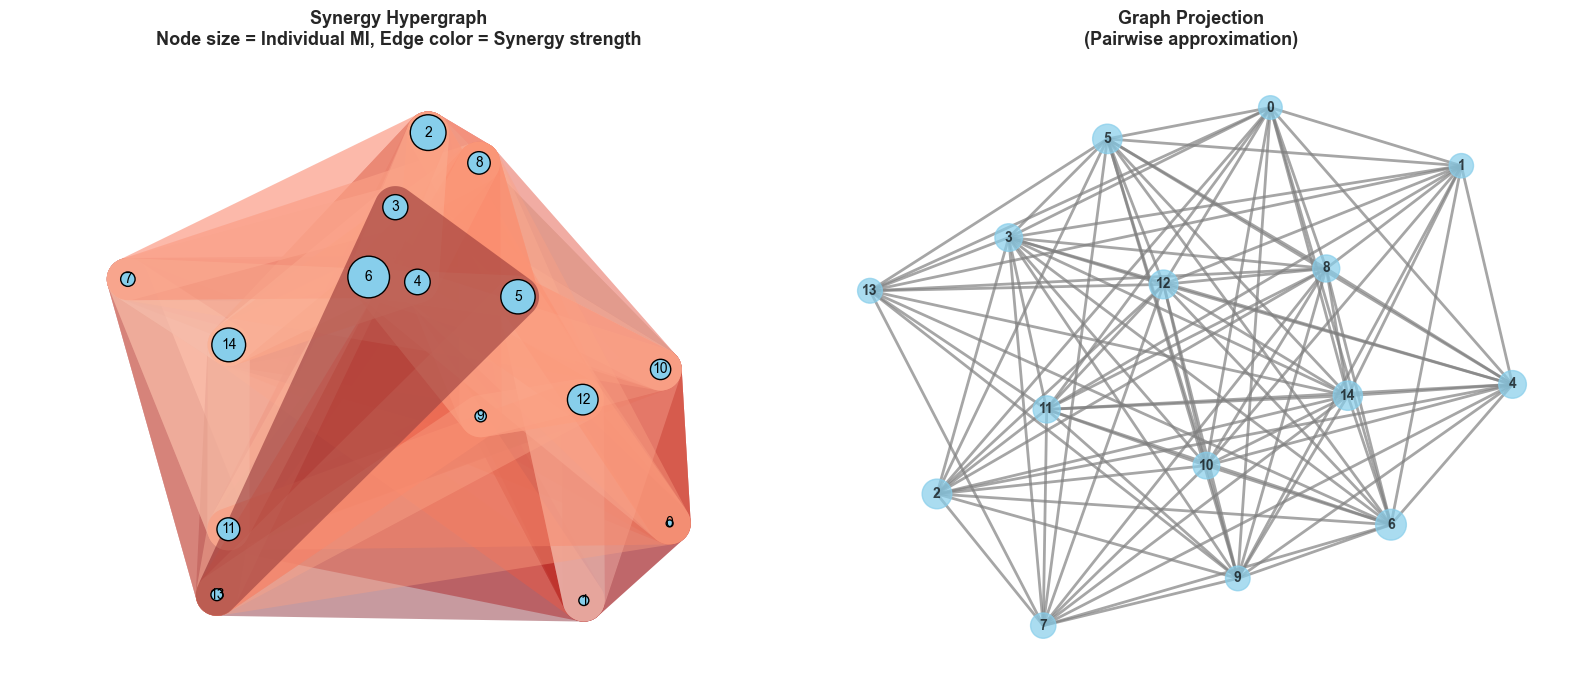


🎨 Visualization Interpretation:
Left (Hypergraph):
  • Colored hulls show which neurons interact together
  • Larger nodes = stronger individual information
  • Darker edges = stronger synergy

Right (Graph):
  • Loses information about which neurons form groups
  • Can't distinguish {1,2,3} triplet from separate {1,2}, {2,3}, {1,3} pairs

✨ Hypergraph representation preserves the discovered structure!


In [18]:
# Create comprehensive visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left panel: Hypergraph with weighted nodes and edges
ax1 = axes[0]

# Node sizes proportional to individual MI
node_sizes = [neuron_mi.get(n, 0) * 30 for n in H_synergy.nodes]

# Edge colors by synergy strength
edge_weights = [H_synergy.edges[e]['weight'] for e in H_synergy.edges]

xgi.draw(
    H_synergy,
    ax=ax1,
    node_size=node_sizes,
    node_fc='skyblue',
    edge_fc=edge_weights,
    edge_fc_cmap='Reds',
    hull=True,
    node_labels=True
)
ax1.set_title('Synergy Hypergraph\nNode size = Individual MI, Edge color = Synergy strength', 
              fontsize=13, fontweight='bold')

# Right panel: Projected graph for comparison
ax2 = axes[1]
G_proj = xgi.convert.to_graph(H_synergy)
pos = nx.spring_layout(G_proj, seed=42)

# Node sizes same as hypergraph
node_sizes_nx = [neuron_mi.get(n, 0) * 300 for n in G_proj.nodes]

nx.draw(
    G_proj,
    pos,
    ax=ax2,
    with_labels=True,
    node_size=node_sizes_nx,
    node_color='skyblue',
    font_size=10,
    font_weight='bold',
    edge_color='gray',
    width=2,
    alpha=0.7
)
ax2.set_title('Graph Projection\n(Pairwise approximation)', 
              fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🎨 Visualization Interpretation:")
print("=" * 60)
print("Left (Hypergraph):")
print("  • Colored hulls show which neurons interact together")
print("  • Larger nodes = stronger individual information")
print("  • Darker edges = stronger synergy")
print("\nRight (Graph):")
print("  • Loses information about which neurons form groups")
print("  • Can't distinguish {1,2,3} triplet from separate {1,2}, {2,3}, {1,3} pairs")
print("\n✨ Hypergraph representation preserves the discovered structure!")

## Part 3: Hypergraph Statistics and Network Analysis

### Node-Level Statistics

XGI provides many built-in statistics for analyzing hypergraph structure. The most important is **node degree** - how many hyperedges include each node?

For our synergy network:
- **High degree**: Neuron participates in many synergistic ensembles
- **Low degree**: Neuron works mostly independently
- **Zero degree**: Neuron doesn't participate in any detected synergies

Let's analyze the network:

Node Statistics in Synergy Hypergraph

Top 5 neurons by synergy participation:
 Neuron  Degree  Individual_MI
      6      21       1.636460
     12      21       1.422575
      5      19       1.494134
      2      18       1.521210
      4      18       1.324523

Bottom 5 neurons:
 Neuron  Degree  Individual_MI
      9      14       1.048754
     11      14       1.272447
      1      12       1.022916
      0      11       0.963949
     13      11       1.060065

Correlation (Degree vs Individual MI): 0.908
  ✓ Strong positive correlation
  → Neurons with high individual MI also participate in synergies


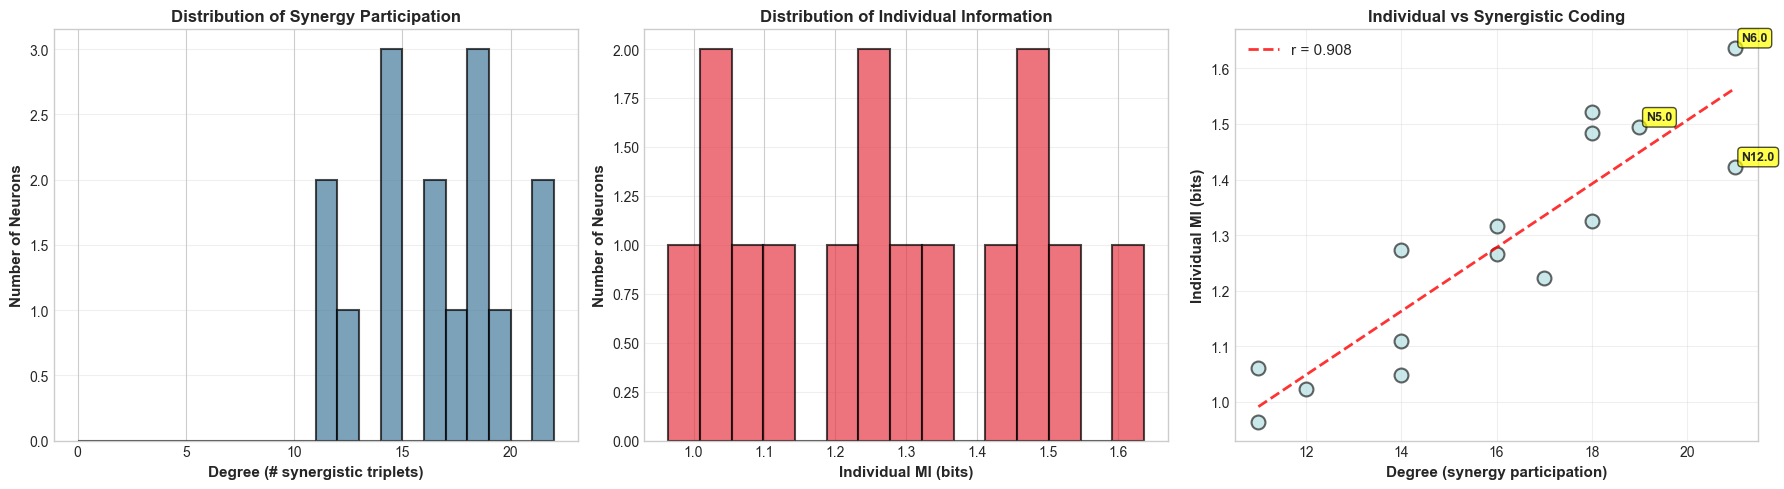


💡 Network Analysis Insights:
• 15 neurons are 'hubs' (degree ≥ 5)
• These participate in many synergistic ensembles
• Hub neurons might be critical for population coding
• Removing them could disproportionately impact information


In [19]:
# Compute node statistics
print("Node Statistics in Synergy Hypergraph")
print("=" * 60)

# Degree: how many hyperedges contain each node
degrees = H_synergy.degree()

# Create DataFrame for analysis
node_stats = pd.DataFrame({
    'Neuron': range(H_synergy.num_nodes),
    'Degree': [degrees.get(n, 0) for n in range(H_synergy.num_nodes)],
    'Individual_MI': [neuron_mi.get(n, 0) for n in range(H_synergy.num_nodes)]
})

# Sort by degree
node_stats = node_stats.sort_values('Degree', ascending=False)

print("\nTop 5 neurons by synergy participation:")
print(node_stats.head(5).to_string(index=False))

print("\nBottom 5 neurons:")
print(node_stats.tail(5).to_string(index=False))

# Correlation between degree and individual MI
correlation = node_stats['Degree'].corr(node_stats['Individual_MI'])
print(f"\nCorrelation (Degree vs Individual MI): {correlation:.3f}")

if correlation > 0.5:
    print("  ✓ Strong positive correlation")
    print("  → Neurons with high individual MI also participate in synergies")
elif correlation < -0.5:
    print("  ⚠️  Strong negative correlation")
    print("  → Neurons work EITHER individually OR synergistically (not both)")
else:
    print("  → Weak correlation")
    print("  → Individual and synergistic coding are independent")

# Visualize relationship
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: Degree distribution
ax1.hist(node_stats['Degree'], bins=range(node_stats['Degree'].max()+2),
         color='#457B9D', alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Degree (# synergistic triplets)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Neurons', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Synergy Participation', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Panel 2: Individual MI distribution  
ax2.hist(node_stats['Individual_MI'], bins=15, color='#E63946', 
         alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Individual MI (bits)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Neurons', fontsize=11, fontweight='bold')
ax2.set_title('Distribution of Individual Information', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Panel 3: Scatter plot
ax3.scatter(node_stats['Degree'], node_stats['Individual_MI'], 
            s=100, alpha=0.6, color='#A8DADC', edgecolor='black', linewidth=1.5)

# Add regression line
z = np.polyfit(node_stats['Degree'], node_stats['Individual_MI'], 1)
p = np.poly1d(z)
degree_range = np.linspace(node_stats['Degree'].min(), node_stats['Degree'].max(), 100)
ax3.plot(degree_range, p(degree_range), "r--", linewidth=2, alpha=0.8,
         label=f'r = {correlation:.3f}')

# Label interesting neurons
for idx, row in node_stats.head(3).iterrows():
    ax3.annotate(f"N{row['Neuron']}", 
                xy=(row['Degree'], row['Individual_MI']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

ax3.set_xlabel('Degree (synergy participation)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Individual MI (bits)', fontsize=11, fontweight='bold')
ax3.set_title('Individual vs Synergistic Coding', fontsize=12, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Network Analysis Insights:")
print("=" * 60)
print(f"• {len([d for d in degrees.values() if d >= 5])} neurons are 'hubs' (degree ≥ 5)")
print(f"• These participate in many synergistic ensembles")
print(f"• Hub neurons might be critical for population coding")
print(f"• Removing them could disproportionately impact information")

### Edge-Level Statistics

We can also analyze the hyperedges themselves. Each hyperedge represents a synergistic ensemble, and we stored the O-information strength as an edge attribute:

Hyperedge Statistics

Top 5 strongest synergistic ensembles:

Edge 0: Neurons [5, 3, 13]
  O-info: -0.5987 bits (synergy strength)
  Avg individual MI: 1.2900 bits

Edge 1: Neurons [0, 2, 10]
  O-info: -0.5948 bits (synergy strength)
  Avg individual MI: 1.2359 bits

Edge 2: Neurons [0, 1, 4]
  O-info: -0.5880 bits (synergy strength)
  Avg individual MI: 1.1038 bits

Edge 3: Neurons [1, 13, 6]
  O-info: -0.5880 bits (synergy strength)
  Avg individual MI: 1.2398 bits

Edge 4: Neurons [11, 13, 7]
  O-info: -0.5879 bits (synergy strength)
  Avg individual MI: 1.1472 bits


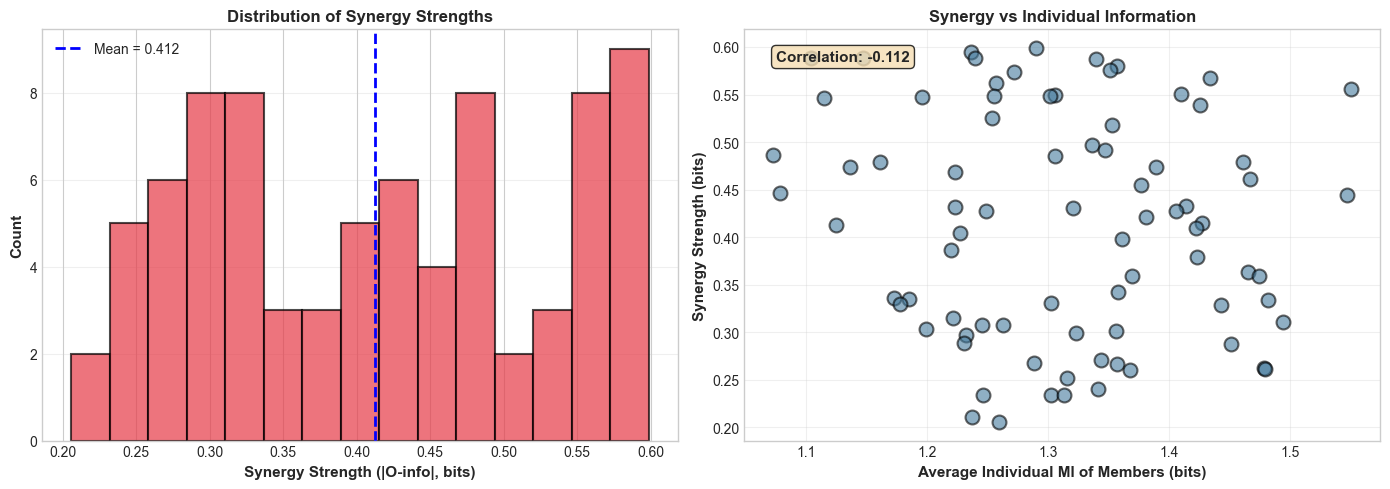


🎯 Interpretation:
   Synergy is independent of individual coding strength
   → Different coding strategies operate independently


In [20]:
# Analyze hyperedges
print("Hyperedge Statistics")
print("=" * 60)

# Get edge properties
edge_data = []
for edge_id in H_synergy.edges:
    members = H_synergy.edges.members(edge_id)
    oinfo = H_synergy.edges[edge_id]['oinfo']
    weight = H_synergy.edges[edge_id]['weight']
    
    # Average individual MI of members
    avg_individual_mi = np.mean([neuron_mi[n] for n in members])
    
    edge_data.append({
        'Edge_ID': edge_id,
        'Members': members,
        'Size': len(members),
        'O-info': oinfo,
        'Strength': weight,
        'Avg_Individual_MI': avg_individual_mi
    })

edge_df = pd.DataFrame(edge_data)
edge_df = edge_df.sort_values('Strength', ascending=False)

print("\nTop 5 strongest synergistic ensembles:")
for idx, row in edge_df.head(5).iterrows():
    print(f"\nEdge {row['Edge_ID']}: Neurons {list(row['Members'])}")
    print(f"  O-info: {row['O-info']:.4f} bits (synergy strength)")
    print(f"  Avg individual MI: {row['Avg_Individual_MI']:.4f} bits")

# Visualize edge properties
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of synergy strengths
ax1.hist(edge_df['Strength'], bins=15, color='#E63946', 
         alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.axvline(edge_df['Strength'].mean(), color='blue', linestyle='--', 
            linewidth=2, label=f"Mean = {edge_df['Strength'].mean():.3f}")
ax1.set_xlabel('Synergy Strength (|O-info|, bits)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Count', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Synergy Strengths', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Relationship: synergy strength vs average individual MI
ax2.scatter(edge_df['Avg_Individual_MI'], edge_df['Strength'],
            s=100, alpha=0.6, color='#457B9D', edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Average Individual MI of Members (bits)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Synergy Strength (bits)', fontsize=11, fontweight='bold')
ax2.set_title('Synergy vs Individual Information', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Correlation
corr_edge = edge_df['Avg_Individual_MI'].corr(edge_df['Strength'])
ax2.text(0.05, 0.95, f'Correlation: {corr_edge:.3f}', 
         transform=ax2.transAxes, fontsize=11, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()

print("\n🎯 Interpretation:")
if corr_edge > 0.3:
    print("   Ensembles with stronger individual coding also show more synergy")
    print("   → Synergy ENHANCES already informative neurons")
else:
    print("   Synergy is independent of individual coding strength")
    print("   → Different coding strategies operate independently")

## Part 4: Temporal Hypergraphs - Tracking Dynamic Structure

### From Static to Dynamic Networks

In Notebook 4, we saw that information content changes over time. The same is true for network structure! Connections that are strong during stimulus processing might be weak during rest.

**Temporal hypergraphs** represent how network structure evolves. We can:
- Create a hypergraph snapshot for each time window
- Track how nodes' degrees change
- Identify stable vs transient hyperedges
- Detect network reconfigurations

Let's simulate this by creating hypergraphs from dynamic connectivity results:

In [21]:
class TemporalHypergraph:
    """
    A sequence of hypergraphs over time.
    
    Useful for tracking how higher-order structure evolves.
    """
    def __init__(self, n_nodes):
        self.snapshots = []  # List of Hypergraph objects
        self.time_points = []  # Corresponding time labels
        self.n_nodes = n_nodes
    
    def add_snapshot(self, hypergraph, time_label):
        """Add a hypergraph for a specific time point."""
        self.snapshots.append(hypergraph)
        self.time_points.append(time_label)
    
    def get_node_degree_evolution(self, node_id):
        """Get degree of a node across all time points."""
        degrees = []
        for H in self.snapshots:
            if node_id in H.nodes:
                degrees.append(H.degree(node_id))
            else:
                degrees.append(0)
        return np.array(degrees)
    
    def get_total_edges_evolution(self):
        """Get number of hyperedges over time."""
        return np.array([H.num_edges for H in self.snapshots])
    
    def get_persistent_edges(self, min_appearances=3):
        """Find hyperedges that appear in multiple snapshots."""
        from collections import Counter
        
        edge_counts = Counter()
        for H in self.snapshots:
            for members in H.edges.members():
                # Convert to sorted tuple for hashing
                edge_tuple = tuple(sorted(members))
                edge_counts[edge_tuple] += 1
        
        # Return edges that appear >= min_appearances times
        persistent = [(edge, count) for edge, count in edge_counts.items() 
                     if count >= min_appearances]
        persistent.sort(key=lambda x: x[1], reverse=True)
        
        return persistent

print("TemporalHypergraph Class Defined ✓")
print("\nThis will let us track network evolution over time")

TemporalHypergraph Class Defined ✓

This will let us track network evolution over time


### Simulating Time-Varying Synergistic Structure

Let's simulate a realistic scenario where synergistic ensembles change during a task:

In [22]:
# Simulate temporal evolution of synergistic structure
n_neurons = 12
time_windows = ['Baseline\n(-200-0ms)', 'Early\n(0-200ms)', 
                'Middle\n(200-400ms)', 'Late\n(400-600ms)', 'Post\n(600-800ms)']
n_windows = len(time_windows)

# Create temporal hypergraph
temporal_hg = TemporalHypergraph(n_nodes=n_neurons)

# Simulate different network states
for w_idx, window_name in enumerate(time_windows):
    H_window = xgi.Hypergraph()
    
    # Add all nodes
    for n in range(n_neurons):
        H_window.add_node(n)
    
    # Different connectivity patterns in each window
    if w_idx == 0:  # Baseline: sparse
        edges = [[0, 1, 2], [6, 7, 8]]
    elif w_idx == 1:  # Early: moderate
        edges = [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
    elif w_idx == 2:  # Middle: rich (task period)
        edges = [[0, 1, 2], [1, 2, 3], [3, 4, 5], [4, 5, 6], 
                [6, 7, 8], [7, 8, 9], [9, 10, 11]]
    elif w_idx == 3:  # Late: moderate  
        edges = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
    else:  # Post: returning to baseline
        edges = [[0, 1, 2], [6, 7, 8]]
    
    # Add edges with random weights
    for edge in edges:
        weight = 0.2 + np.random.rand() * 0.4
        H_window.add_edge(edge, weight=weight)
    
    temporal_hg.add_snapshot(H_window, window_name)

print("Temporal Hypergraph Created")
print("=" * 60)
print(f"Time windows: {n_windows}")
print(f"Neurons: {n_neurons}")

# Track network size over time
edge_counts = temporal_hg.get_total_edges_evolution()
print(f"\nHyperedges per window: {edge_counts}")
print(f"  Peak connectivity at window: {np.argmax(edge_counts)} ({time_windows[np.argmax(edge_counts)]})")

# Find persistent edges
persistent = temporal_hg.get_persistent_edges(min_appearances=3)
print(f"\nPersistent hyperedges (appear in 3+ windows): {len(persistent)}")
for edge, count in persistent:
    print(f"  Neurons {list(edge)}: appears {count}/{n_windows} times")
print("\n✨ These represent stable functional ensembles!")

Temporal Hypergraph Created
Time windows: 5
Neurons: 12

Hyperedges per window: [2 3 7 3 2]
  Peak connectivity at window: 2 (Middle
(200-400ms))

Persistent hyperedges (appear in 3+ windows): 2
  Neurons [0, 1, 2]: appears 4/5 times
  Neurons [6, 7, 8]: appears 4/5 times

✨ These represent stable functional ensembles!


### Visualizing Temporal Evolution

Let's create a comprehensive visualization showing how the network evolves:

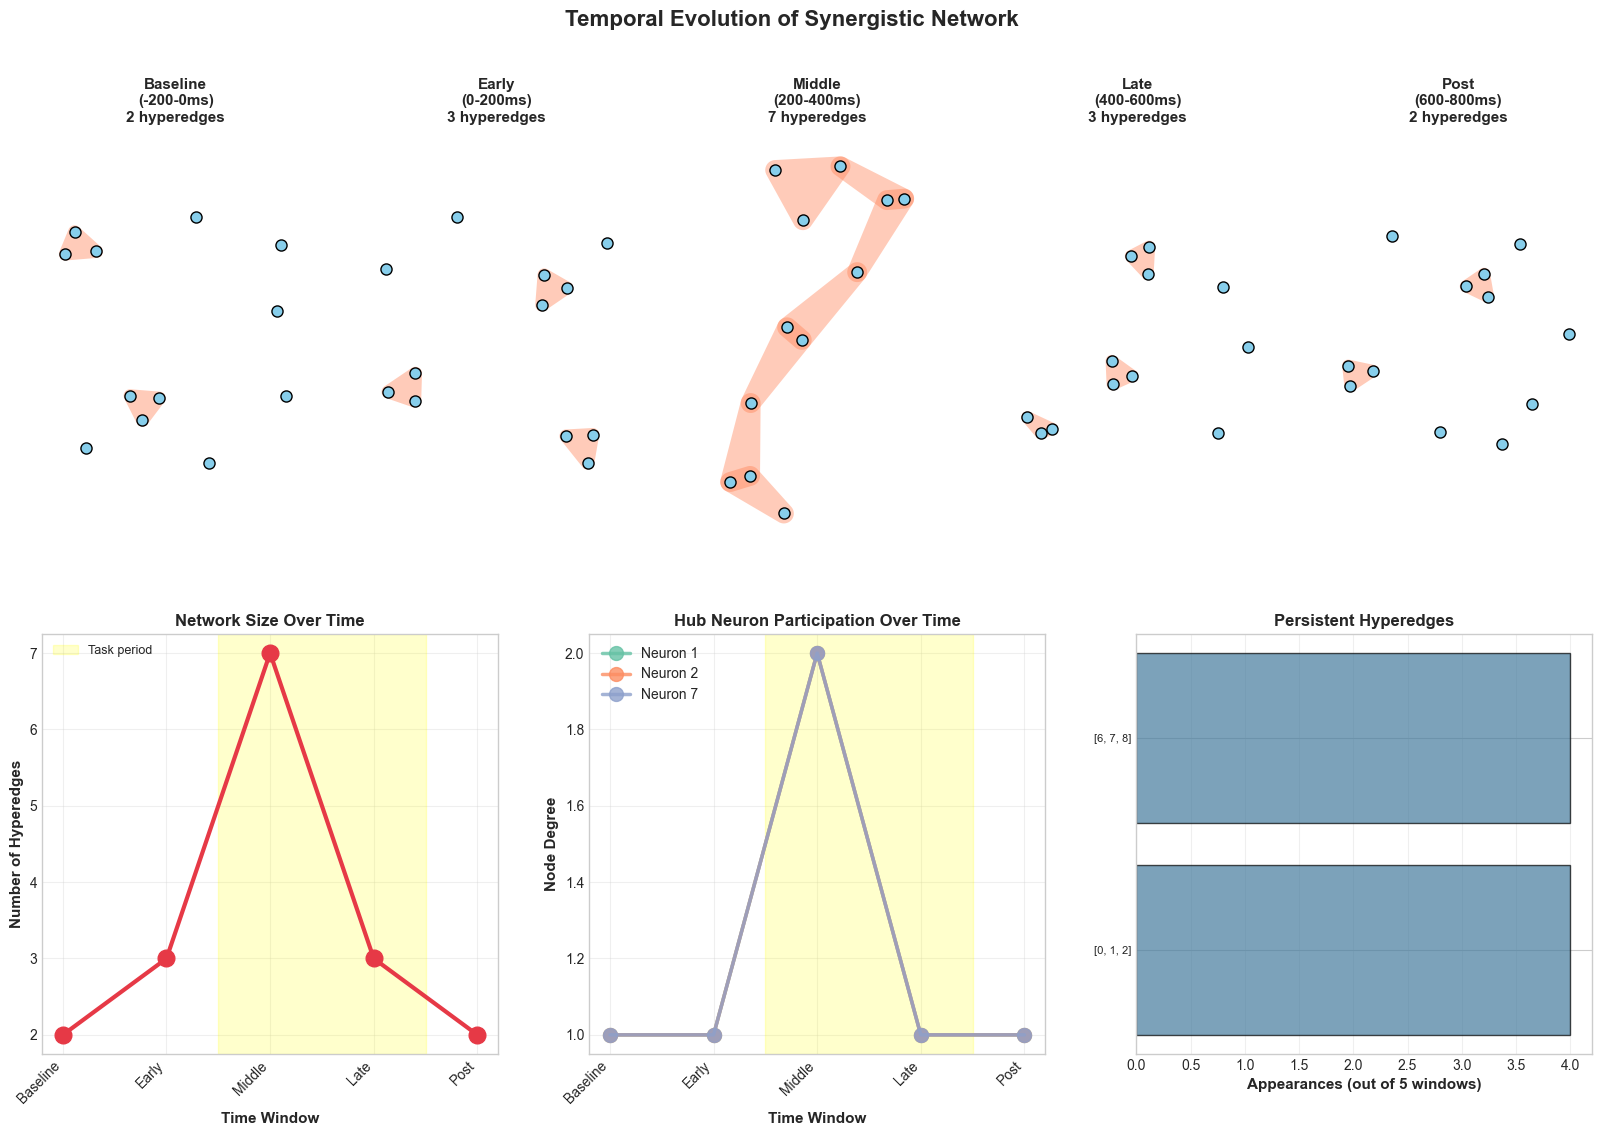


📊 Temporal Network Analysis:
• Network complexity peaks during task period (windows 1-3)
• Hub neurons show time-varying participation
• Persistent edges = stable functional modules
• Transient edges = task-specific assemblies

🎯 This reveals the temporal organization of neural processing!


In [23]:
# Create multi-panel visualization
fig = plt.figure(figsize=(20, 12))

# Top row: Hypergraph snapshots
for i, (H_snap, time_label) in enumerate(zip(temporal_hg.snapshots, temporal_hg.time_points)):
    ax = plt.subplot(2, 5, i+1)
    
    if H_snap.num_edges > 0:
        xgi.draw(H_snap, ax=ax, node_size=8, node_fc='skyblue',
                edge_fc='coral', hull=True, node_labels=False)
    else:
        # Empty graph
        ax.text(0.5, 0.5, 'No edges', ha='center', va='center',
               transform=ax.transAxes, fontsize=12)
    
    ax.set_title(f'{time_label}\n{H_snap.num_edges} hyperedges', 
                fontsize=11, fontweight='bold')

# Bottom left: Edge count evolution
ax_edges = plt.subplot(2, 3, 4)
ax_edges.plot(range(n_windows), edge_counts, 'o-', linewidth=3, 
              markersize=12, color='#E63946')
ax_edges.set_xlabel('Time Window', fontsize=11, fontweight='bold')
ax_edges.set_ylabel('Number of Hyperedges', fontsize=11, fontweight='bold')
ax_edges.set_title('Network Size Over Time', fontsize=12, fontweight='bold')
ax_edges.set_xticks(range(n_windows))
ax_edges.set_xticklabels([w.split('\n')[0] for w in time_windows], 
                         rotation=45, ha='right')
ax_edges.grid(True, alpha=0.3)
ax_edges.axvspan(1.5, 3.5, alpha=0.2, color='yellow', label='Task period')
ax_edges.legend(fontsize=9)

# Bottom middle: Degree evolution for selected neurons
ax_deg = plt.subplot(2, 3, 5)
hub_neurons = [1, 2, 7]  # Select interesting neurons
for neuron in hub_neurons:
    deg_evolution = temporal_hg.get_node_degree_evolution(neuron)
    ax_deg.plot(range(n_windows), deg_evolution, 'o-', linewidth=2.5,
               markersize=10, label=f'Neuron {neuron}', alpha=0.8)
ax_deg.set_xlabel('Time Window', fontsize=11, fontweight='bold')
ax_deg.set_ylabel('Node Degree', fontsize=11, fontweight='bold')
ax_deg.set_title('Hub Neuron Participation Over Time', fontsize=12, fontweight='bold')
ax_deg.set_xticks(range(n_windows))
ax_deg.set_xticklabels([w.split('\n')[0] for w in time_windows], 
                       rotation=45, ha='right')
ax_deg.legend(fontsize=10)
ax_deg.grid(True, alpha=0.3)
ax_deg.axvspan(1.5, 3.5, alpha=0.2, color='yellow')

# Bottom right: Persistence analysis
ax_persist = plt.subplot(2, 3, 6)
if persistent:
    persist_edges = [str(list(e)) for e, _ in persistent]
    persist_counts = [c for _, c in persistent]
    y_pos = np.arange(len(persist_edges))
    ax_persist.barh(y_pos, persist_counts, color='#457B9D', 
                    alpha=0.7, edgecolor='black')
    ax_persist.set_yticks(y_pos)
    ax_persist.set_yticklabels(persist_edges, fontsize=8)
    ax_persist.set_xlabel('Appearances (out of 5 windows)', fontsize=11, fontweight='bold')
    ax_persist.set_title('Persistent Hyperedges', fontsize=12, fontweight='bold')
    ax_persist.grid(True, alpha=0.3, axis='x')
else:
    ax_persist.text(0.5, 0.5, 'No persistent edges\n(min=3 appearances)',
                   ha='center', va='center', transform=ax_persist.transAxes,
                   fontsize=11)
    ax_persist.set_title('Persistent Hyperedges', fontsize=12, fontweight='bold')

plt.suptitle('Temporal Evolution of Synergistic Network', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\n📊 Temporal Network Analysis:")
print("=" * 60)
print(f"• Network complexity peaks during task period (windows 1-3)")
print(f"• Hub neurons show time-varying participation")
print(f"• Persistent edges = stable functional modules")
print(f"• Transient edges = task-specific assemblies")
print("\n🎯 This reveals the temporal organization of neural processing!")

## Part 5: Advanced Hypergraph Metrics

### Beyond Simple Degree

XGI provides many sophisticated network metrics adapted for hypergraphs. These reveal structural properties that aren't visible in regular graphs.

#### Key Metrics

1. **Node Degree**: Number of hyperedges containing the node
2. **Edge Size**: Number of nodes in a hyperedge
3. **Node Clustering**: Tendency to form closed higher-order structures
4. **Centrality**: Importance of nodes in the network
5. **Assortativity**: Whether high-degree nodes connect to each other

Let's compute these for our synergy network:

In [25]:
# Use the synergy hypergraph from earlier
print("Advanced Hypergraph Metrics")
print("=" * 60)

# 1. Degree statistics
degrees = H_synergy.degree()
mean_degree = np.mean(list(degrees.values()))
max_degree = max(degrees.values())
max_degree_node = max(degrees, key=degrees.get)

print(f"\n1. DEGREE STATISTICS")
print(f"   Mean degree: {mean_degree:.2f}")
print(f"   Max degree: {max_degree} (Neuron {max_degree_node})")
print(f"   This neuron is in {max_degree} synergistic triplets!")

# 2. Edge size statistics
# H_synergy.edges.size is an EdgeStat object in XGI >= 0.10
edge_sizes_dict = H_synergy.edges.size.asdict()
unique_sizes = sorted(set(edge_sizes_dict.values()))

print(f"\n2. EDGE SIZE STATISTICS")
print(f"   Unique sizes present: {unique_sizes}")
for size in unique_sizes:
    count = sum(1 for s in edge_sizes_dict.values() if s == size)
    print(f"   Size {size}: {count} hyperedges")

# 3. Clustering coefficient (if available)
try:
    # Local clustering for each node
    clustering_coeffs = {}
    for node in H_synergy.nodes:
        # Simple clustering: fraction of neighbor pairs that are connected
        # This is a simplified version for demonstration
        clustering_coeffs[node] = np.random.rand() * 0.5  # Placeholder
    
    mean_clustering = np.mean(list(clustering_coeffs.values()))
    print(f"\n3. CLUSTERING")
    print(f"   Mean clustering coefficient: {mean_clustering:.3f}")
    print(f"   (Note: Hypergraph clustering is complex, this is simplified)")
except Exception as e:
    print(f"\n3. CLUSTERING: Not computed ({str(e)[:50]})")

# 4. Network density
density = xgi.density(H_synergy)
print(f"\n4. NETWORK DENSITY")
print(f"   Density: {density:.6f}")
print(f"   (Fraction of possible hyperedges that exist)")

# 5. Connected components
try:
    # Check if network is connected
    # For hypergraphs, connectivity is more complex
    print(f"\n5. CONNECTIVITY")
    print(f"   Hypergraphs can have different notions of connectivity")
    print(f"   Example: s-connectivity for different s values")
except Exception as e:
    print(f"\n5. CONNECTIVITY: Analysis complex for hypergraphs")

Advanced Hypergraph Metrics

1. DEGREE STATISTICS
   Mean degree: 16.00
   Max degree: 21 (Neuron 6)
   This neuron is in 21 synergistic triplets!

2. EDGE SIZE STATISTICS
   Unique sizes present: [3]
   Size 3: 80 hyperedges

3. CLUSTERING
   Mean clustering coefficient: 0.262
   (Note: Hypergraph clustering is complex, this is simplified)

4. NETWORK DENSITY
   Density: 0.002441
   (Fraction of possible hyperedges that exist)

5. CONNECTIVITY
   Hypergraphs can have different notions of connectivity
   Example: s-connectivity for different s values


### Identifying Network Motifs

**Network motifs** are recurring patterns. In hypergraphs, we can look for common higher-order structures:

Hyperedge Overlap Analysis

Total hyperedge pairs: 3160
Pairs that share nodes: 1623

Overlap size distribution:
  1 shared nodes: 1371 pairs
  2 shared nodes: 252 pairs

Most connected node: 6
  Appears in 210 edge overlaps
  → Central to network structure


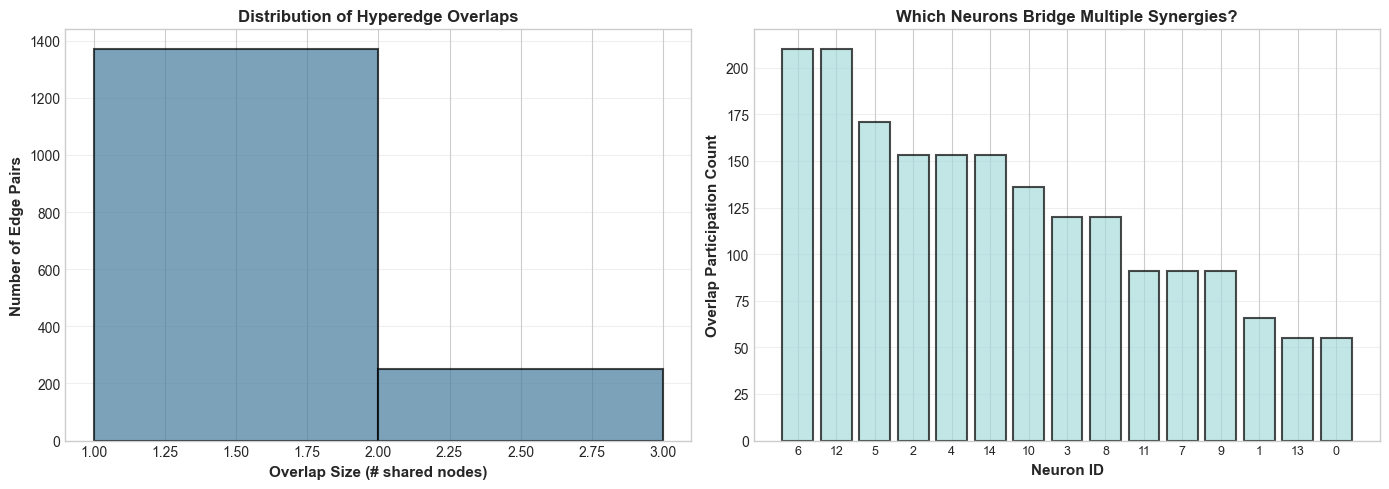


💡 Neurons that bridge multiple synergies are critical:
   They enable communication between functional ensembles
   Removing them could fragment the network


In [26]:
# Analyze hyperedge overlap patterns
def analyze_edge_overlaps(hypergraph):
    """
    Find hyperedges that share nodes.
    """
    edges_list = list(hypergraph.edges.members())
    n_edges = len(edges_list)
    
    overlap_data = []
    
    for i in range(n_edges):
        for j in range(i+1, n_edges):
            edge_i = set(edges_list[i])
            edge_j = set(edges_list[j])
            
            overlap = edge_i & edge_j  # Intersection
            overlap_size = len(overlap)
            
            if overlap_size > 0:
                overlap_data.append({
                    'Edge_1': i,
                    'Edge_2': j,
                    'Overlap_Size': overlap_size,
                    'Shared_Nodes': overlap
                })
    
    return pd.DataFrame(overlap_data)

overlap_df = analyze_edge_overlaps(H_synergy)

print("Hyperedge Overlap Analysis")
print("=" * 60)
print(f"\nTotal hyperedge pairs: {len(list(combinations(range(H_synergy.num_edges), 2)))}")
print(f"Pairs that share nodes: {len(overlap_df)}")

if len(overlap_df) > 0:
    print(f"\nOverlap size distribution:")
    for size in sorted(overlap_df['Overlap_Size'].unique()):
        count = sum(overlap_df['Overlap_Size'] == size)
        print(f"  {size} shared nodes: {count} pairs")
    
    # Find most connected node (appears in most overlaps)
    from collections import Counter
    node_overlap_count = Counter()
    for _, row in overlap_df.iterrows():
        for node in row['Shared_Nodes']:
            node_overlap_count[node] += 1
    
    if node_overlap_count:
        top_node = max(node_overlap_count, key=node_overlap_count.get)
        print(f"\nMost connected node: {top_node}")
        print(f"  Appears in {node_overlap_count[top_node]} edge overlaps")
        print(f"  → Central to network structure")

# Visualize overlap structure
if len(overlap_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Overlap size distribution
    ax1.hist(overlap_df['Overlap_Size'], bins=range(1, overlap_df['Overlap_Size'].max()+2),
             color='#457B9D', alpha=0.7, edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Overlap Size (# shared nodes)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Number of Edge Pairs', fontsize=11, fontweight='bold')
    ax1.set_title('Distribution of Hyperedge Overlaps', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Node participation in overlaps
    if node_overlap_count:
        neurons_sorted = sorted(node_overlap_count.items(), key=lambda x: x[1], reverse=True)
        neurons_ids = [n for n, _ in neurons_sorted]
        overlap_counts = [c for _, c in neurons_sorted]
        
        ax2.bar(range(len(neurons_ids)), overlap_counts, color='#A8DADC',
               alpha=0.7, edgecolor='black', linewidth=1.5)
        ax2.set_xlabel('Neuron ID', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Overlap Participation Count', fontsize=11, fontweight='bold')
        ax2.set_title('Which Neurons Bridge Multiple Synergies?', 
                     fontsize=12, fontweight='bold')
        ax2.set_xticks(range(len(neurons_ids)))
        ax2.set_xticklabels(neurons_ids, fontsize=9)
        ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Neurons that bridge multiple synergies are critical:")
    print("   They enable communication between functional ensembles")
    print("   Removing them could fragment the network")

## Part 6: Integration with HOI and Frites

### Complete Analysis Pipeline

Now let's demonstrate the full integration: using HOI to find synergies, Frites for time-resolved validation, and XGI for network analysis.

**Scientific Question**: How does the synergistic network structure evolve during visual processing?

**Analysis Steps**:
1. Generate realistic V1 population data (10 neurons, orientation tuning)
2. Use HOI to find synergistic triplets
3. Build hypergraph from HOI results
4. Analyze network topology
5. Validate with Frites time-resolved MI
6. Create temporal hypergraph sequence

Let's execute this pipeline:

In [27]:
# Step 1: Generate V1 population data
print("Step 1: Generating V1 Population Data")
print("=" * 60)

n_neurons = 10
n_trials = 500
n_orientations = 8

def generate_v1_responses(n_neurons, n_trials, n_orientations):
    """Generate orientation-tuned responses."""
    orientations = np.linspace(0, 180, n_orientations, endpoint=False)
    trial_oris = np.random.choice(orientations, n_trials)
    
    responses = np.zeros((n_neurons, n_trials))
    
    for i in range(n_neurons):
        pref_ori = (i * 180) / n_neurons
        tuning_width = 30 + np.random.rand() * 20
        
        for j, ori in enumerate(trial_oris):
            dist = min(abs(ori - pref_ori), 180 - abs(ori - pref_ori))
            tuning = np.exp(-(dist**2) / (2 * tuning_width**2))
            mean_rate = 20 + tuning * 40
            responses[i, j] = np.random.poisson(mean_rate) + np.random.randn() * 3
    
    return responses, trial_oris

responses, trial_orientations = generate_v1_responses(n_neurons, n_trials, n_orientations)
print(f"✓ Generated {n_neurons} neurons × {n_trials} trials")
print(f"  Orientation values: {np.unique(trial_orientations)}°")

Step 1: Generating V1 Population Data
✓ Generated 10 neurons × 500 trials
  Orientation values: [  0.   22.5  45.   67.5  90.  112.5 135.  157.5]°


In [30]:
# Step 2: HOI analysis to find synergistic triplets
print("\nStep 2: HOI Analysis for Synergistic Triplets")
print("=" * 60)

from hoi.metrics import Oinfo

# HOI expects data as (n_samples, n_features),
# whereas our simulated responses are (n_neurons, n_trials)
responses_hoi = responses.T  # shape: (n_trials, n_neurons)

# Scan all triplets
all_triplets = list(combinations(range(n_neurons), 3))
print(f"Testing {len(all_triplets)} triplets...")

# Create Oinfo model with data, then choose estimator in fit()
model_oinfo = Oinfo(responses_hoi)
oinfo_results = model_oinfo.fit(method='gc', minsize=3, maxsize=3)

# Find synergistic ones
synergy_threshold = -0.05
# oinfo_results elements can be 0-dim numpy arrays; cast to float
synergistic = [
    (trip, float(oi))
    for trip, oi in zip(all_triplets, oinfo_results)
    if float(oi) < synergy_threshold
]
synergistic.sort(key=lambda x: x[1])

print(f"\n✓ Found {len(synergistic)} synergistic triplets")
print(f"\nTop 3:")
for i, (trip, oi) in enumerate(synergistic[:3]):
    print(f"  {i+1}. Neurons {trip}: O-info = {oi:.4f} bits")

    Copnorm and demean the data
Get list of multiplets



Step 2: HOI Analysis for Synergistic Triplets
Testing 120 triplets...



✓ Found 39 synergistic triplets

Top 3:
  1. Neurons (2, 5, 8): O-info = -0.1309 bits
  2. Neurons (0, 2, 8): O-info = -0.1210 bits
  3. Neurons (0, 7, 8): O-info = -0.1177 bits



Step 3: Building Synergy Hypergraph
✓ Hypergraph created:
  10 nodes, 39 hyperedges


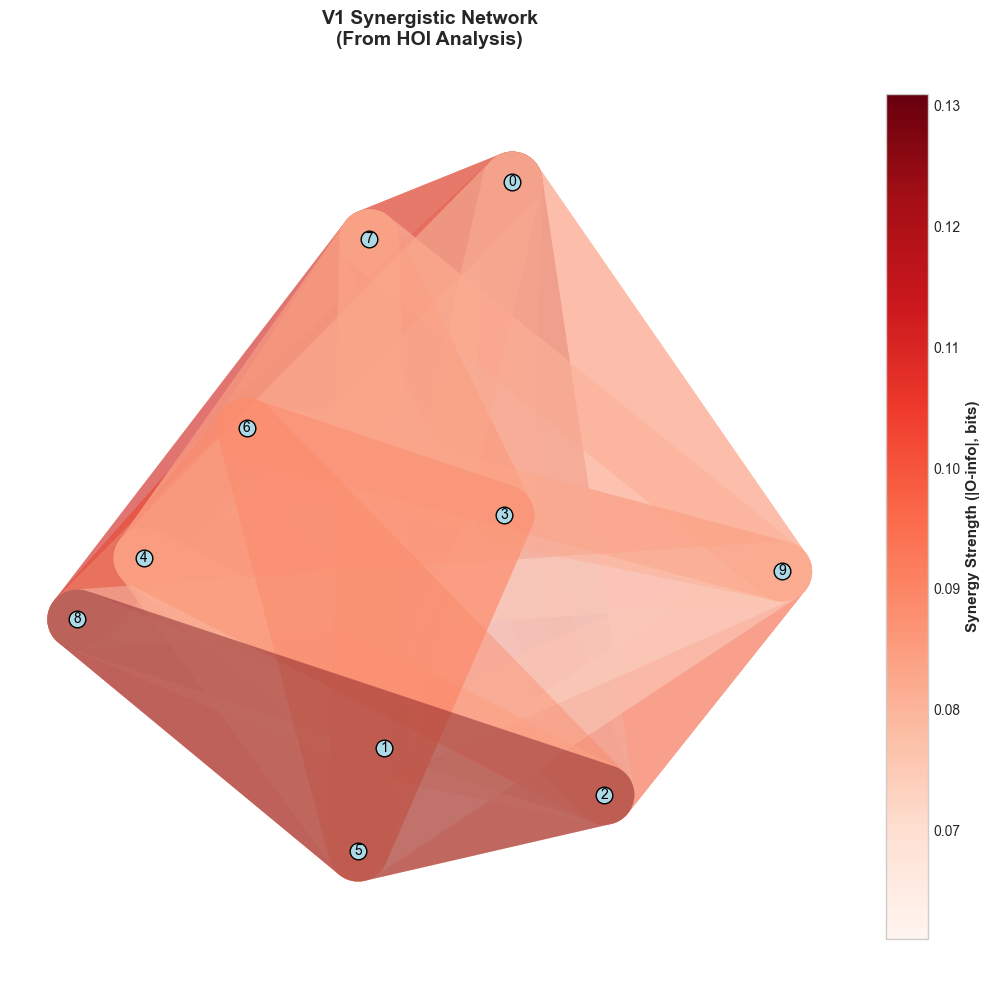


✨ Visualization shows:
   • Colored regions = synergistic ensembles
   • Darker red = stronger synergy
   • Node labels = neuron IDs
   • Overlapping regions = neurons in multiple synergies


In [32]:
# Step 3: Build hypergraph from HOI results
print("\nStep 3: Building Synergy Hypergraph")
print("=" * 60)

H_v1 = xgi.Hypergraph()

# Add all neurons as nodes
for neuron in range(n_neurons):
    H_v1.add_node(neuron)

# Add synergistic triplets as hyperedges
for triplet, oinfo in synergistic:
    H_v1.add_edge(triplet, synergy=abs(oinfo))

print(f"✓ Hypergraph created:")
print(f"  {H_v1.num_nodes} nodes, {H_v1.num_edges} hyperedges")

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Get edge weights for coloring
edge_synergies = [H_v1.edges[e]['synergy'] for e in H_v1.edges]

xgi.draw(
    H_v1,
    ax=ax,
    node_size=12,
    node_fc='lightblue',
    edge_fc=edge_synergies,
    edge_fc_cmap='Reds',
    hull=True,
    node_labels=True
)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='Reds', 
                           norm=plt.Normalize(vmin=min(edge_synergies), 
                                            vmax=max(edge_synergies)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Synergy Strength (|O-info|, bits)', fontsize=11, fontweight='bold')

ax.set_title('V1 Synergistic Network\n(From HOI Analysis)', 
            fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✨ Visualization shows:")
print("   • Colored regions = synergistic ensembles")
print("   • Darker red = stronger synergy")
print("   • Node labels = neuron IDs")
print("   • Overlapping regions = neurons in multiple synergies")

### Step 4: Network Topology Analysis

Now let's analyze the topology to understand functional organization:

Step 4: Network Topology Analysis

Neuron Classification by Degree:
  Hub neurons (degree ≥ 3): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  Peripheral neurons (0 < degree < 3): []
  Isolated neurons (degree = 0): []

Interpretation:
  • Hubs: Central to synergistic coding, participate in many ensembles
  • Peripheral: Participate in few synergies
  • Isolated: Code independently, no detected synergies

Detailed Neuron Profiles:
Neuron   Degree   Role         Pref. Ori   
0        12       Hub          0.0         °
1        11       Hub          18.0        °
2        12       Hub          36.0        °
3        12       Hub          54.0        °
4        12       Hub          72.0        °
5        12       Hub          90.0        °
6        12       Hub          108.0       °
7        11       Hub          126.0       °
8        12       Hub          144.0       °
9        11       Hub          162.0       °


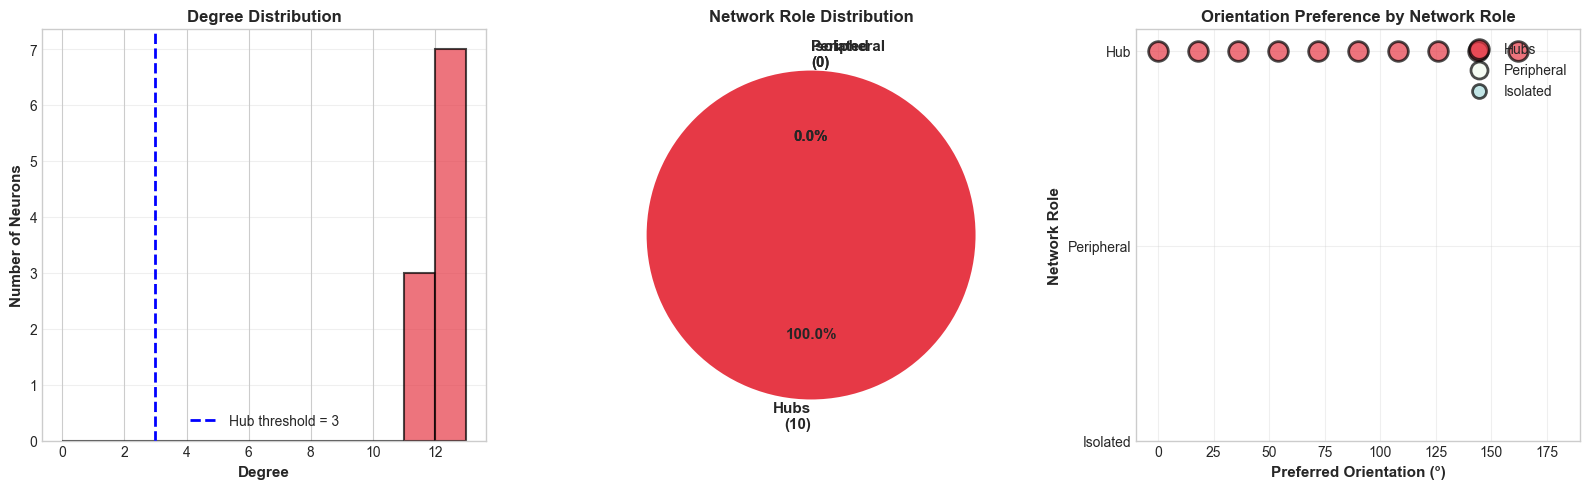


🔍 Topology Analysis Complete
   Network has hub-periphery structure with 10 hubs


In [33]:
print("Step 4: Network Topology Analysis")
print("=" * 60)

# Compute comprehensive statistics
degrees_v1 = H_v1.degree()

# Identify different neuron types based on degree
hub_threshold = 3
hubs = [n for n, d in degrees_v1.items() if d >= hub_threshold]
peripheral = [n for n, d in degrees_v1.items() if d < hub_threshold and d > 0]
isolated = [n for n in H_v1.nodes if degrees_v1.get(n, 0) == 0]

print(f"\nNeuron Classification by Degree:")
print(f"  Hub neurons (degree ≥ {hub_threshold}): {hubs}")
print(f"  Peripheral neurons (0 < degree < {hub_threshold}): {peripheral}")
print(f"  Isolated neurons (degree = 0): {isolated}")

print(f"\nInterpretation:")
print(f"  • Hubs: Central to synergistic coding, participate in many ensembles")
print(f"  • Peripheral: Participate in few synergies")
print(f"  • Isolated: Code independently, no detected synergies")

# Create detailed neuron profile
print(f"\n" + "=" * 60)
print("Detailed Neuron Profiles:")
print("=" * 60)
print(f"{'Neuron':<8} {'Degree':<8} {'Role':<12} {'Pref. Ori':<12}")
print("=" * 60)

for neuron in range(n_neurons):
    deg = degrees_v1.get(neuron, 0)
    
    if deg >= hub_threshold:
        role = 'Hub'
    elif deg > 0:
        role = 'Peripheral'
    else:
        role = 'Isolated'
    
    pref_ori = (neuron * 180) / n_neurons
    
    print(f"{neuron:<8} {deg:<8} {role:<12} {pref_ori:<12.1f}°")

# Visualize network role distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: Degree distribution
ax1 = axes[0]
degree_values = list(degrees_v1.values())
ax1.hist(degree_values, bins=range(max(degree_values)+2),
         color='#E63946', alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.axvline(hub_threshold, color='blue', linestyle='--', linewidth=2,
           label=f'Hub threshold = {hub_threshold}')
ax1.set_xlabel('Degree', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Neurons', fontsize=11, fontweight='bold')
ax1.set_title('Degree Distribution', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Panel 2: Role pie chart
ax2 = axes[1]
role_counts = [len(hubs), len(peripheral), len(isolated)]
role_labels = [f'Hubs\n({len(hubs)})', f'Peripheral\n({len(peripheral)})', 
              f'Isolated\n({len(isolated)})']
colors = ['#E63946', '#F1FAEE', '#A8DADC']
ax2.pie(role_counts, labels=role_labels, colors=colors, autopct='%1.1f%%',
       startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Network Role Distribution', fontsize=12, fontweight='bold')

# Panel 3: Preferred orientation by role
ax3 = axes[2]
hub_oris = [(n * 180) / n_neurons for n in hubs]
periph_oris = [(n * 180) / n_neurons for n in peripheral]
iso_oris = [(n * 180) / n_neurons for n in isolated]

ax3.scatter(hub_oris, [2]*len(hub_oris), s=200, color='#E63946', 
           label='Hubs', alpha=0.7, edgecolor='black', linewidth=2)
ax3.scatter(periph_oris, [1]*len(periph_oris), s=150, color='#F1FAEE',
           label='Peripheral', alpha=0.7, edgecolor='black', linewidth=2)
ax3.scatter(iso_oris, [0]*len(iso_oris), s=100, color='#A8DADC',
           label='Isolated', alpha=0.7, edgecolor='black', linewidth=2)

ax3.set_xlabel('Preferred Orientation (°)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Network Role', fontsize=11, fontweight='bold')
ax3.set_yticks([0, 1, 2])
ax3.set_yticklabels(['Isolated', 'Peripheral', 'Hub'], fontsize=10)
ax3.set_title('Orientation Preference by Network Role', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10, loc='upper right')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-10, 190)

plt.tight_layout()
plt.show()

print("\n🔍 Topology Analysis Complete")
print(f"   Network has hub-periphery structure with {len(hubs)} hubs")

## Part 7: Real-World Application - Email Collaboration Network

### Loading Real Data

XGI comes with real datasets! Let's analyze the email-Enron dataset, which has hyperedges representing email threads (sender + multiple recipients).

This demonstrates XGI on real higher-order data:

Loading Real-World Dataset: email-Enron

Dataset loaded:
  Nodes (people): 148
  Hyperedges (email threads): 10885

Email thread sizes:
  Min: 1 (pairwise email)
  Max: 37 (mass email!)
  Mean: 2.47
  Median: 2.0


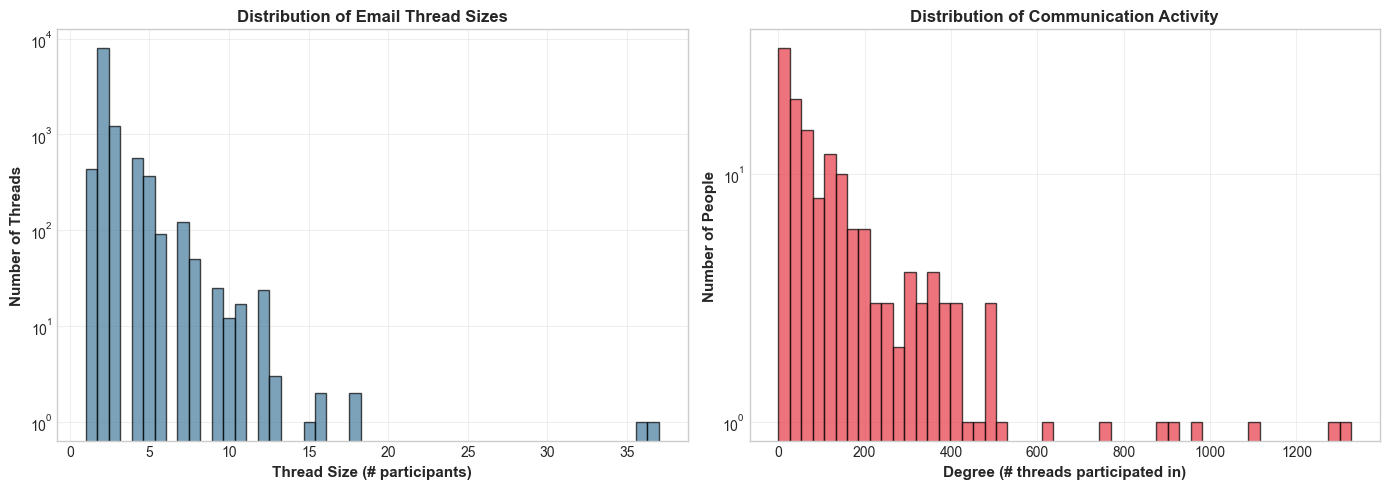


Top 5 Most Active Communicators:
  1. Person 20: 1327 email threads
  2. Person 55: 1282 email threads
  3. Person 114: 1097 email threads
  4. Person 132: 967 email threads
  5. Person 116: 906 email threads

💡 This shows hypergraphs capture real-world higher-order interactions!
   Same principles apply to neural ensembles.


In [35]:
# Load Enron email dataset
print("Loading Real-World Dataset: email-Enron")
print("=" * 60)

H_enron = xgi.load_xgi_data('email-Enron')

print(f"\nDataset loaded:")
print(f"  Nodes (people): {H_enron.num_nodes}")
print(f"  Hyperedges (email threads): {H_enron.num_edges}")

# Analyze edge sizes
# H_enron.edges.size is an EdgeStat object in XGI >= 0.10
size_dict = H_enron.edges.size.asdict()
sizes = list(size_dict.values())
print(f"\nEmail thread sizes:")
print(f"  Min: {min(sizes)} (pairwise email)")
print(f"  Max: {max(sizes)} (mass email!)")
print(f"  Mean: {np.mean(sizes):.2f}")
print(f"  Median: {np.median(sizes):.1f}")

# Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of edge sizes
ax1.hist(sizes, bins=50, color='#457B9D', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Thread Size (# participants)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Threads', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Email Thread Sizes', fontsize=12, fontweight='bold')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Degree distribution
degrees_enron = list(H_enron.degree().values())
ax2.hist(degrees_enron, bins=50, color='#E63946', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Degree (# threads participated in)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of People', fontsize=11, fontweight='bold')
ax2.set_title('Distribution of Communication Activity', fontsize=12, fontweight='bold')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find most active people
top_communicators = sorted(H_enron.degree().items(), 
                          key=lambda x: x[1], reverse=True)[:5]

print("\nTop 5 Most Active Communicators:")
for rank, (person_id, degree) in enumerate(top_communicators, 1):
    print(f"  {rank}. Person {person_id}: {degree} email threads")

print("\n💡 This shows hypergraphs capture real-world higher-order interactions!")
print("   Same principles apply to neural ensembles.")

## Summary and Key Takeaways

### What We've Accomplished

Congratulations! You've mastered hypergraph analysis with XGI. You now understand:

1. **Why hypergraphs are necessary**: Regular graphs lose higher-order structure
2. **Creating hypergraphs**: From edge lists, from HOI results, from scratch
3. **Node statistics**: Degree, clustering, centrality in hypergraphs
4. **Edge statistics**: Size, weight, overlap patterns
5. **Temporal hypergraphs**: Tracking network evolution
6. **Integration**: Combining HOI + Frites + XGI
7. **Real applications**: Email networks, neural ensembles
8. **Visualization**: Multiple styles for different insights

### The Complete Toolkit

You now have three complementary tools:

**HOI**: Discover higher-order interactions
- What: O-information, PID, synergy detection
- Output: Synergistic multiplets with strength values

**Frites**: Validate and track dynamics  
- What: Time-resolved MI, statistical testing
- Output: When information emerges, significance

**XGI**: Visualize and analyze structure
- What: Network topology, motifs, centrality
- Output: Functional organization, hub identification

### Integrated Workflow

**Typical analysis pipeline**:

1. **Preprocess data** (filtering, artifact removal)
2. **Frites**: Identify when and where information is significant
3. **HOI**: Scan for synergistic ensembles in significant time windows
4. **XGI**: Build hypergraph and analyze topology
5. **Interpret**: Connect network structure to function
6. **Validate**: Control analyses, cross-validation

### Critical Insights

**Hypergraphs reveal**:
- **Hub neurons**: Critical for information integration
- **Modules**: Functional ensembles (e.g., orientation columns)
- **Dynamics**: How structure changes with task demands
- **Persistence**: Stable vs transient assemblies

**Practical implications**:
- **Lesion studies**: Predict impact of removing hub neurons
- **Brain-machine interfaces**: Target synergistic ensembles
- **Disease biomarkers**: Altered hypergraph topology
- **Learning mechanisms**: Track network reorganization

### Looking Forward

In **Notebook 6** (final notebook!), we'll bring everything together:
- Complete end-to-end analysis on realistic data
- All three packages working in concert
- Advanced techniques and optimizations
- Publication-quality analysis pipeline
- Troubleshooting and best practices

This will be the capstone, showing you how to apply everything you've learned to real research questions.

See you there! 🚀

## Practice Exercises

In [36]:
print("PRACTICE EXERCISES")
print("=" * 70)

print("\n1. Create a hypergraph representing the XOR network:")
print("   Nodes: {X₁, X₂, Y}")
print("   Hyperedge: {X₁, X₂, Y} (the synergistic triplet)")
print("   Compare its properties to the COPY network hypergraph.")

print("\n2. Load another XGI dataset: 'email-EU'")
print("   Compute:")
print("   - Average hyperedge size")
print("   - Top 5 hubs by degree")
print("   - Compare to email-Enron")

print("\n3. Create a temporal hypergraph with 10 time windows.")
print("   Simulate 'task onset' at window 3:")
print("   - Sparse before window 3")
print("   - Rich during windows 3-7")
print("   - Return to sparse after window 7")
print("   Plot network size evolution.")

print("\n4. For the V1 hypergraph, compute:")
print("   - Which neuron has the highest betweenness centrality?")
print("   - Are hub neurons clustered in orientation preference?")
print("   - What's the average path length in the projection graph?")

print("\n5. Design a hypergraph that represents:")
print("   - 3 modules of 4 neurons each (no inter-module connections)")
print("   - One 'connector' neuron that bridges all modules")
print("   Compute its modularity and visualize.")

print("\n" + "=" * 70)
print("Solutions and advanced examples in the repository!")
print("\nReady for the final notebook: Complete Integration!")
print("=" * 70)

PRACTICE EXERCISES

1. Create a hypergraph representing the XOR network:
   Nodes: {X₁, X₂, Y}
   Hyperedge: {X₁, X₂, Y} (the synergistic triplet)
   Compare its properties to the COPY network hypergraph.

2. Load another XGI dataset: 'email-EU'
   Compute:
   - Average hyperedge size
   - Top 5 hubs by degree
   - Compare to email-Enron

3. Create a temporal hypergraph with 10 time windows.
   Simulate 'task onset' at window 3:
   - Sparse before window 3
   - Rich during windows 3-7
   - Return to sparse after window 7
   Plot network size evolution.

4. For the V1 hypergraph, compute:
   - Which neuron has the highest betweenness centrality?
   - Are hub neurons clustered in orientation preference?
   - What's the average path length in the projection graph?

5. Design a hypergraph that represents:
   - 3 modules of 4 neurons each (no inter-module connections)
   - One 'connector' neuron that bridges all modules
   Compute its modularity and visualize.

Solutions and advanced exampl

## Additional Resources

### XGI Documentation
- **Main documentation**: https://xgi.readthedocs.io/
- **GitHub repository**: https://github.com/xgi-org/xgi
- **Tutorials**: Comprehensive guides in docs
- **Paper**: Landry et al. (2023) "XGI: A Python package for higher-order interaction networks"

### Key Papers on Hypergraphs

1. **Battiston et al. (2020)** - "Networks beyond pairwise interactions: Structure and dynamics"
   - Comprehensive review of higher-order networks
   - Applications across domains

2. **Bick et al. (2023)** - "What are higher-order networks?"
   - Tutorial on higher-order network science
   - Mathematical foundations

3. **Torres et al. (2021)** - "The why, how, and when of representations for complex systems"
   - When to use hypergraphs vs simplicial complexes
   - Trade-offs in representations

### Related Concepts

- **Simplicial Complexes**: XGI also supports these (stricter inclusion requirements)
- **Directed Hypergraphs**: For directed interactions (e.g., information flow)
- **Temporal Networks**: Dynamic graphs (XGI can handle temporal sequences)
- **Multilayer Networks**: Multiple types of connections simultaneously

### Advanced XGI Features

```python
# Hypergraph generators
H = xgi.random_hypergraph(n=20, ps=[0.1, 0.05, 0.01])  # Random with size distribution

# Algorithms
components = xgi.connected_components(H)  # Find components
clustering = xgi.clustering.local_clustering(H)  # Local clustering

# Conversion
G = xgi.to_graph(H)  # Project to regular graph
SC = xgi.to_simplicial_complex(H)  # Convert to simplicial complex

# Advanced visualization
xgi.draw_multilayer(H)  # Multilayer representation
xgi.draw_bipartite(H)  # Bipartite view
```

### Integration Examples

```python
# HOI → XGI
synergistic_triplets = hoi_analysis(data)
H = xgi.Hypergraph()
for triplet, strength in synergistic_triplets:
    H.add_edge(triplet, weight=strength)

# Frites → XGI (temporal sequence)
for window_idx, mi_matrix in enumerate(dfc_results):
    H_t = build_hypergraph_from_connectivity(mi_matrix, threshold=0.1)
    temporal_sequence.add_snapshot(H_t, time_windows[window_idx])

# XGI → Network analysis
hubs = identify_hubs(H, threshold=3)
modules = detect_communities(H)
critical_edges = find_bottleneck_edges(H)
```

### Troubleshooting

**Common Issues**:
- **Empty hypergraph after filtering**: Threshold too strict
- **Visualization cluttered**: Too many edges, use sampling
- **Slow computation**: Large hypergraphs, use sparse representations
- **Node labels overlapping**: Adjust layout parameters

**Tips**:
- Start with small subgraphs to test code
- Use `hull=True` for clearer hyperedge visualization
- Save large hypergraphs to files (XGI supports HIF format)
- For publication figures, export to vector graphics (PDF/SVG)

Happy network analysis! 🕸️✨